In [1]:
from collections import defaultdict
from datetime import datetime
import dill
from itertools import permutations, combinations
import json
import math
from operator import itemgetter
import os
import pickle
import random
import re
import time

import numpy as np
import pandas as pd
import pandas as pd
import scipy

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

import little_mallet_wrapper as lmw

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text
sns.set(style='ticks', font_scale=1.2)
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

<br><br>

# Load data

In [2]:
decameron_path = '../data/csv/decameron.csv'


In [3]:
decameron_df = pd.read_csv(decameron_path)

In [4]:
len(decameron_df.index)

100

In [5]:
decameron_df.sample(3)

ID  Day  Story   Narrator Gender  \
2   1-3    1      3   filomena  woman   
55  6-6    6      6  fiammetta  woman   
8   1-9    1      9     elissa  woman   

                                                 Text  
2   Poi che, commendata da tutti la novella di Nei...  
55  Ridevano ancora le donne della bella e presta ...  
8   A Elissa restava l'ultimo comandamento della r...

<br><br>

# Try topic modeling

In [6]:
stopwords = ['il', 'lo', 'la', 'i', 'le', 'gli', 'è', 'tu', 'tuo', 'tua', 'suo', 'sue',
			  'suoi', 'sua', 'loro', 'lei', 'quale', 'quali', 'questa', 'questo', 'cosa',
			  'che', 'non', 'per', 'come', 'egli', 'voi', 'del', 'della', 'così',  'più',
			  'con', 'col', 'cui', 'una', 'qual', 'fu', 'fosse', 'era', 'lui', 'quello',
			  'senza', 'alla', 'dove', 'già', 'ogni', 'vostra', 'vostro', 'vostri', 'vostre',
			  'nostro', 'nostra', 'nostre', 'nostri', 'altro', 'altra', 'altre', 'altri',
			  'molto', 'molta', 'molte', 'molti', 'nel', 'ciò', 'quella', 'bene', 'ben',
			  'ella', 'disse', 'sopra', 'noi', 'alessandro',  'ser', 'esser', 'essere', 'fa', 'fare',
			  'alcuna', 'alcun', 'alcuno', 'ora', 'far', 'quando', 'pietro', 
			  'filippo', 'alberto', 'ferondo', 'gianni', 'fatto',
			  'ché', 'ricciardo', 'riccardo', 'chichibio',
			  'bruno', 'gisippo', 'federigo', 'mai', 'ma', 'poi', 'aveva', 'mio', 'mia', 'masetto',
			  'rinaldo', 'nella', 'nello', 'lor', 'erano', 'lor', 'gerbino', 
			  'gabriotto', 'tanto', 'tanti', 'tante', 'tanta', 'cose', 'delle',
			  'giosefo',
			  'quanto', 'dentro', 'tutto', 'tutta', 'tutti', 'tutte',
			  'nelle', 'giù', 'assai', 'avea', 'dire', 'avendo', 'essendo', 'guiglielmo',
			  'anichino', 'fece', 'sia', 'ancora', 'martuccio', 'efigenia', 'antigono', 'giannetta',
			  'uno', 'avessi', 'quivi', 'sofronia', 'chi',
			  'giacomino', 'ghino', 'allora', 'angiulieri', 'geri', 'pavia',
			  'puccio', 'quindi', 'pirro' , 'perché', 'salabaetto', 'giannotto', 'dico',
			  'dall', 'dal', 'son', 'qui', 'hai', 'sono', 'aver', 'all', 'essi', 'due', 'sapere', 'alle', 'quelle',
			  'queste', 'due', 'tra', 'fine', 'dell', 'del', 'avesse', 'hanno', 'oltre', 'quantunque', 'diceva', 'dice',
			  'tre', 'quegli', 'fatti', 'stato', 'stata', 'dalla', 'agli', 'avere', 'alquanto', 'adunque', 'fanno', 'furono',
			  'cominciò', 'fossero', 'andò', 'incominciò',' solamente', 'degli', 'fatta', 'ebbe', 'coloro', 'questi', 'miei',
			  'nell', 'secondo', 'elle', 'solamente', 'dopo', 'pero', "panfilo", "neifile", "filomena", "dioneo", "fiammetta",
	"emilia", "filostrato", "lauretta", "elissa", "pampinea", 'colei', 'quel', 'state', 'stati', 'stato', 'stata', 'dello']

In [7]:
training_texts = []
original_texts = []
training_narrators = []
training_genders = []

for i, r in decameron_df.iterrows():
    _chunks = [' '.join(r['Text'].split()[i:i+200]) for i in range(0, len(r['Text'].split()), 200)]
    _processed_chunks = [lmw.process_string(c, stop_words=stopwords, remove_short_words=False).strip() for c in _chunks]
    _processed_chunks = [c for c in _processed_chunks if len(c.split()) >= 20]

    for i, c in enumerate(_processed_chunks):
        training_texts.append(c)
        original_texts.append(_chunks[i])
        training_narrators.append(r['Narrator'])
        training_genders.append(r['Gender'])

len(training_texts), len(training_narrators), len(training_genders)

(1203, 1203, 1203)

In [9]:
num_topics = 20  
output_directory_path = 'output' 
#path_to_mallet = '/Volumes/Passport-1/packages/mallet-2.0.8/bin/mallet'
path_to_mallet = "~/mallet-2.0.8/bin/mallet"


In [13]:
topic_keys, topic_distributions = lmw.quick_train_topic_model(path_to_mallet, 
                                                              output_directory_path, 
                                                              num_topics, 
                                                              training_texts)

Importing data...
Complete
Training topic model...
Complete


In [14]:
assert(len(topic_distributions) == len(training_texts))

In [15]:
for i, t in enumerate(topic_keys):
    print(i, '\t', ' '.join(t[:10]))

0 	 messer torello saladino uomini gentili famigliare cavaliere famigliari signori città
1 	 donna amore giovane tempo marito moglie bella amor costei gentil
2 	 prete nicostrato geloso badessa belcolore bocca monache castaldo mutolo doglio
3 	 messer messere proposto zima cavaliere cisti lizio vescovo lambertuccio paganino
4 	 diavolo dio rustico tingoccio meuccio compar inferno cavalla comare ninferno
5 	 andreuccio costoro cavaliere nastagio morte pozzo fuggire castello gridando cani
6 	 calandrino buffalmacco maestro medico zeppa spinelloccio porco pietre brigata moglie
7 	 donna camera fante casa notte letto uscio marito dormire allato
8 	 casa gran parte giovane appresso uomo insieme prima forte tempo
9 	 donne uomini novella reina chiamato uomo città forse giovani volte
10 	 conte figliuolo currado figliuola figliuoli madre gualtieri padre anni età
11 	 mare denari nave bernabò oro ambruogiuolo mercatantia soldano vento genova
12 	 arriguccio gola marchese fortarrigo corpo giudi

In [16]:
for _topic in range(0, num_topics):
    print('---------------------------------------------------------------------------')
    print('TOPIC ' + str(_topic) + ': ' + ' '.join(topic_keys[_topic][:5]))
    print('---------------------------------------------------------------------------')
    print()
    for p, d in lmw.get_top_docs(original_texts, topic_distributions, topic_index=_topic, n=3):
        print(round(p, 4), d)
        print()

---------------------------------------------------------------------------
TOPIC 0: messer torello saladino uomini gentili
---------------------------------------------------------------------------

0.5372 da messer Torel conosciuti: ma pure alla donna rispose l'un di loro: “Queste son, madonna, grandissime cose e da non dover di leggier pigliare, se i vostri prieghi a ciò non ci strignessero, alli quali dir di no non si puote.” Questo fatto, essendo già messer Torel ritornato, la donna, accomandatigli a Dio, da lor si partì, e di simili cose di ciò, quali a loro si convenieno, fece provedere a' famigliari. Messer Torello con molti prieghi impetrò da loro che tutto quel dì dimorasson con lui; per che, poi che dormito ebbero, vestitesi le robe loro, con messer Torello alquanto cavalcar per la città, e l'ora della cena venuta con molti onorevoli compagni magnificamente cenarono. E quando tempo fu, andatisi a riposare, come il giorno venne sù si levarono e trovarono in luogo de' loro ro

In [17]:
def plot_categories_by_topics_heatmap(labels, 
                                      topic_distributions, 
                                      topic_keys, 
                                      output_path=None,
                                      target_labels=None,
                                      dim=None):
    
    # Combine the labels and distributions into a list of dictionaries.
    dicts_to_plot = []
    for _label, _distribution in zip(labels, topic_distributions):
        if not target_labels or _label in target_labels:
            for _topic_index, _probability in enumerate(_distribution):
                dicts_to_plot.append({'Probability': float(_probability),
                                      'Category': _label,
                                      'Topic': 'Topic ' + str(_topic_index).zfill(2) + ': ' + ' '.join(topic_keys[_topic_index][:5])})

    # Create a dataframe, format it for the heatmap function, and normalize the columns.
    df_to_plot = pd.DataFrame(dicts_to_plot)
    df_wide = df_to_plot.pivot_table(index='Category', 
                                     columns='Topic', 
                                     values='Probability')
    df_norm_col=(df_wide-df_wide.mean())/df_wide.std()
        
    # Show the final plot.
    if dim:
        plt.figure(figsize=dim)
    sns.set(style='ticks', font_scale=1.2)
    ax = sns.heatmap(df_norm_col, cmap='Blues')    
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    plt.xticks(rotation=30, ha='left')
    plt.tight_layout()
    if output_path:
        plt.savefig(output_path)
    plt.show()

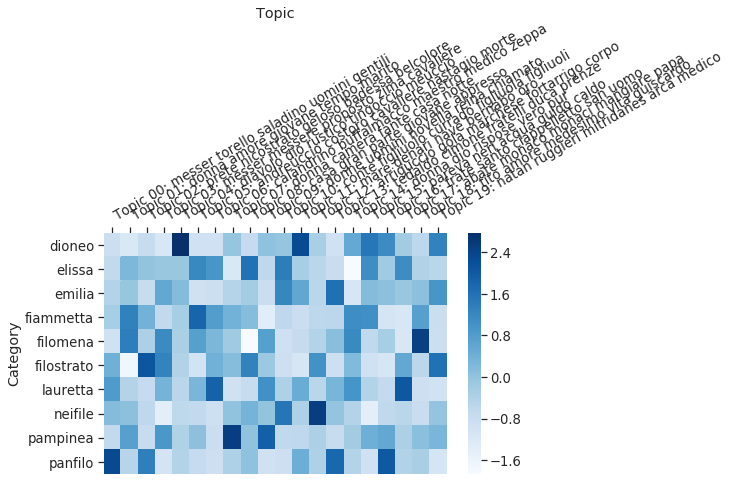

In [18]:
plot_categories_by_topics_heatmap(training_narrators,
                                  topic_distributions,
                                  topic_keys, 
                                  output_directory_path + '/narrators_by_topics.pdf',
                                  dim=(10,7))

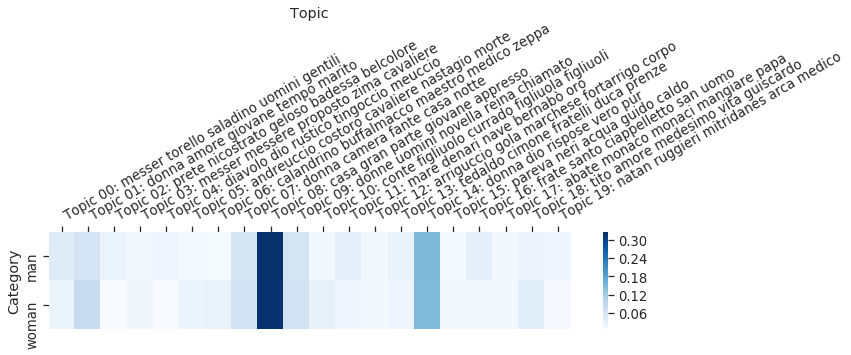

In [20]:
def plot_categories_by_topics_heatmap(labels, 
                                      topic_distributions, 
                                      topic_keys, 
                                      output_path=None,
                                      target_labels=None,
                                      dim=None):
    
    # Combine the labels and distributions into a list of dictionaries.
    dicts_to_plot = []
    for _label, _distribution in zip(labels, topic_distributions):
        if not target_labels or _label in target_labels:
            for _topic_index, _probability in enumerate(_distribution):
                dicts_to_plot.append({'Probability': float(_probability),
                                      'Category': _label,
                                      'Topic': 'Topic ' + str(_topic_index).zfill(2) + ': ' + ' '.join(topic_keys[_topic_index][:5])})

    # Create a dataframe, format it for the heatmap function, and normalize the columns.
    df_to_plot = pd.DataFrame(dicts_to_plot)
    df_wide = df_to_plot.pivot_table(index='Category', 
                                     columns='Topic', 
                                     values='Probability')
    # df_norm_col=(df_wide-df_wide.mean())/df_wide.std()
        
    # Show the final plot.
    if dim:
        plt.figure(figsize=dim)
    sns.set(style='ticks', font_scale=1.2)
    ax = sns.heatmap(df_wide, cmap='Blues')    
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    plt.xticks(rotation=30, ha='left')
    plt.tight_layout()
    if output_path:
        plt.savefig(output_path)
    plt.show()
    
plot_categories_by_topics_heatmap(training_genders,
                                  topic_distributions,
                                  topic_keys, 
                                  output_directory_path + '/narrators_by_topics.pdf',
                                  dim=(12,5))

<br><br>

# Try logistic regression

In [32]:
# first, we want to split into train and test datasets
# for training, we want to make sure that we have chunked into
# small pieces of text. We are going to divide the text into 100-word
# pieces (and not worry about leftover for simplicity)
# we also want to make sure that the train chunks come from stories
# that do not overlap with the test stories

# so to start, we will sample 80% (80) of the stories for train,
# 20% for test, and then we will chunk them

# num_train is the number of stories that will be used for training; 
# 10 - num_train is number used for test, per storyteller
def storyteller_train_test_split(storyteller, num_train=8):
	# get story ids for the story teller
	storyteller_ids =  decameron_df[decameron_df['Narrator']==storyteller]['ID'].tolist()
	train_set_story_ids = random.sample(storyteller_ids, 8)
	test_set_story_ids = [x for x in storyteller_ids if x not in train_set_story_ids]
	return train_set_story_ids, test_set_story_ids

# 30 stories by men, 70 by women
# so for 80/20 train/test, we want 24 of men, 56 of the women for train
def gender_test_train_split(gender, prop_train=.8):
	gender_ids =  decameron_df[decameron_df['Gender']==gender]['ID'].tolist()
	num_train = int(prop_train * len(gender_ids))
	train_gender_ids = random.sample(gender_ids, num_train)
	test_gender_ids = [x for x in gender_ids if x not in train_gender_ids]
	return train_gender_ids, test_gender_ids

def pair_test_train_split(storyteller1, storyteller2, num_train=8):
	train_1, test_1 = storyteller_train_test_split(storyteller1, num_train)
	train_2, test_2 = storyteller_train_test_split(storyteller2, num_train)
	train_1.extend(train_2)
	test_1.extend(test_2)
	return train_1, test_1

# construct the training and test sets. We will chunk each story
# into n words (not caring about the remainder) and each chunk will
# be a data point. The corresponding label will be the storyteller for
# to story to which the chunk belongs 
def chunk_story(story_id, n):
	story = decameron_df[decameron_df['ID']==story_id]
	text = story['Text'].item()

	# there has to be a better way to do this, but whatever
	words = text.split()
	# rejoin words every n words, put into list
	story_chunks = [" ".join(words[i:i+n]) for i in range(0, len(words), n)]
	return story_chunks, story['Narrator'].item(), story['Gender'].item()

# iterate through train story ids, chunk story, put into train set; same
# for test set
def create_data_set(story_ids, chunk_size, use_gender):
	texts = []
	labels = []
	for story_id in story_ids:
		# heinous factoring...whatever
		story_chunks, storyteller, gender = chunk_story(story_id, chunk_size)
		for chunk in story_chunks:
			# add each chunk as a traing put for that storyteller
			texts.append(chunk)
			if use_gender:
				labels.append(gender)
			else:
				labels.append(storyteller)
	return texts, labels

<br><br>
## Storytellers

In [63]:
def get_storyteller_datasets():
    train_set_story_ids = []
    test_set_story_ids = []

    chunk_size = 100

    for storyteller in decameron_df['Narrator'].unique():
        storyteller_train_ids, storyteller_test_ids = storyteller_train_test_split(storyteller)
        train_set_story_ids.extend(storyteller_train_ids)
        test_set_story_ids.extend(storyteller_test_ids)

    train_texts, train_labels = create_data_set(train_set_story_ids, chunk_size, use_gender=False)
    test_texts, test_labels = create_data_set(test_set_story_ids, chunk_size, use_gender=False)
    return train_texts, train_labels, test_texts, test_labels

In [64]:
train_texts, train_labels, test_texts, test_labels = get_storyteller_datasets()
len(train_texts), len(train_labels), len(test_texts), len(test_labels)

(1990, 1990, 399, 399)

In [65]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_texts)
X_test = vectorizer.transform(test_texts)

In [66]:
model = LogisticRegression(C=1).fit(X_train, train_labels)
predictions = model.predict(X_test)

In [72]:
print(classification_report(test_labels, predictions))
lr_results = classification_report(test_labels, predictions, output_dict=True)

#lr_results['accuracy']

              precision    recall  f1-score   support

      dioneo       0.12      0.28      0.17        32
      elissa       0.00      0.00      0.00        78
      emilia       0.00      0.00      0.00        14
   fiammetta       0.06      0.09      0.07        32
    filomena       0.00      0.00      0.00        41
  filostrato       0.00      0.00      0.00        34
    lauretta       0.10      0.12      0.11        25
     neifile       0.00      0.00      0.00        53
    pampinea       0.08      0.07      0.07        45
     panfilo       0.08      0.27      0.12        45

    accuracy                           0.08       399
   macro avg       0.04      0.08      0.05       399
weighted avg       0.04      0.08      0.05       399



/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/pyth

0.07518796992481203

In [90]:
# run above task n times
#print(lr_results)

column_names = ['run_id','dioneo', 'elissa', 'emilia', 'fiammetta', 'filomena', 
                    'filostrato', 'lauretta', 'neifile', 'pampinea', 'panfilo', 
                    'accuracy', 'macro_avg', 'weighted_avg']
results_df = df = pd.DataFrame(columns = column_names)  
    

In [92]:
def run_lr_n_times(n, results_df):
    # dataframe with results   
    
    for i in range(1,n+1):
        print("Running {} of {}".format(i, n))
        train_texts, train_labels, test_texts, test_labels = get_storyteller_datasets()

        vectorizer = TfidfVectorizer()
        X_train = vectorizer.fit_transform(train_texts)
        X_test = vectorizer.transform(test_texts)

        model = LogisticRegression(C=1).fit(X_train, train_labels)
        predictions = model.predict(X_test)

        lr_results = classification_report(test_labels, predictions, output_dict=True)
    
        results_df = results_df.append({'run_id': i, 
                                        'dioneo': lr_results['dioneo'],
                                        'elissa': lr_results['elissa'],
                                        'emilia': lr_results['emilia'],
                                        'fiammetta': lr_results['fiammetta'],
                                        'filomena': lr_results['filomena'],
                                        'filostrato': lr_results['filostrato'],
                                        'lauretta': lr_results['lauretta'],
                                        'neifile': lr_results['neifile'],
                                        'pampinea': lr_results['pampinea'],
                                        'panfilo': lr_results['panfilo'],
                                        'accuracy': lr_results['accuracy'],
                                        'macro_avg': lr_results['macro avg'],
                                        'weighted_avg': lr_results['weighted avg'],
                                       }, ignore_index=True)
    
    return results_df

In [93]:
n = 10
n_results = run_lr_n_times(n, results_df)

Running 1 of 10


/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Running 2 of 10
Running 3 of 10
Running 4 of 10
Running 5 of 10
Running 6 of 10
Running 7 of 10
Running 8 of 10


/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Running 9 of 10


/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Running 10 of 10


/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [94]:
n_results

run_id                                             dioneo  \
0      1  {'precision': 0.05128205128205128, 'recall': 0...   
1      2  {'precision': 0.39285714285714285, 'recall': 0...   
2      3  {'precision': 0.08943089430894309, 'recall': 0...   
3      4  {'precision': 0.08771929824561403, 'recall': 0...   
4      5  {'precision': 0.056818181818181816, 'recall': ...   
5      6  {'precision': 0.08108108108108109, 'recall': 0...   
6      7  {'precision': 0.11224489795918367, 'recall': 0...   
7      8  {'precision': 0.15584415584415584, 'recall': 0...   
8      9  {'precision': 0.12, 'recall': 0.20454545454545...   
9     10  {'precision': 0.2727272727272727, 'recall': 0....   

                                              elissa  \
0  {'precision': 0.0, 'recall': 0.0, 'f1-score': ...   
1  {'precision': 0.04, 'recall': 0.03703703703703...   
2  {'precision': 0.0, 'recall': 0.0, 'f1-score': ...   
3  {'precision': 0.08333333333333333, 'recall': 0...   
4  {'precision': 0.0, 'recall': 0.0, 'f1-score': ...   
5  {'precision': 0.0, 'recall': 0.0, 'f1-score': ...   
6  {'precision': 0.058823529411764705, 'recall': ...   
7  {'precision': 0.0, 'recall': 0.0, 'f1-score': ...   
8  {'precision': 0.0, 'recall': 0.0, 'f1-score': ...   
9  {'precision': 0.0, 'recall': 0.0, 'f1-score': ...   

                                              emilia  \
0  {'precision': 0.0, 'recall': 0.0, 'f1-score': ...   
1  {'precision': 0.0, 'recall': 0.0, 'f1-score': ...   
2  {'precision': 0.08695652173913043, 'recall': 0...   
3  {'precision': 0.0, 'recall': 0.0, 'f1-score': ...   
4  {'precision': 0.16666666666666666, 'recall': 0...   
5  {'precision': 0.0, 'recall': 0.0, 'f1-score': ...   
6  {'precision': 0.0, 'recall': 0.0, 'f1-score': ...   
7  {'precision': 0.06666666666666667, 'recall': 0...   
8  {'precision': 0.1, 'recall': 0.058823529411764...   
9  {'precision': 0.0, 'recall': 0.0, 'f1-score': ...   

                                           fiammetta  \
0  {'precision': 0.0, 'recall': 0.0, 'f1-score': ...   
1  {'precision': 0.014084507042253521, 'recall': ...   
2  {'precision': 0.028169014084507043, 'recall': ...   
3  {'precision': 0.023255813953488372, 'recall': ...   
4  {'precision': 0.06896551724137931, 'recall': 0...   
5  {'precision': 0.061224489795918366, 'recall': ...   
6  {'precision': 0.036585365853658534, 'recall': ...   
7  {'precision': 0.5, 'recall': 0.029411764705882...   
8  {'precision': 0.09375, 'recall': 0.07692307692...   
9  {'precision': 0.05405405405405406, 'recall': 0...   

                                            filomena  \
0  {'precision': 0.0, 'recall': 0.0, 'f1-score': ...   
1  {'precision': 0.0, 'recall': 0.0, 'f1-score': ...   
2  {'precision': 0.0, 'recall': 0.0, 'f1-score': ...   
3  {'precision': 0.08, 'recall': 0.04878048780487...   
4  {'precision': 0.0410958904109589, 'recall': 0....   
5  {'precision': 0.0, 'recall': 0.0, 'f1-score': ...   
6  {'precision': 0.10526315789473684, 'recall': 0...   
7  {'precision': 0.0, 'recall': 0.0, 'f1-score': ...   
8  {'precision': 0.047619047619047616, 'recall': ...   
9  {'precision': 0.0, 'recall': 0.0, 'f1-score': ...   

                                          filostrato  \
0  {'precision': 0.0, 'recall': 0.0, 'f1-score': ...   
1  {'precision': 0.0, 'recall': 0.0, 'f1-score': ...   
2  {'precision': 0.0, 'recall': 0.0, 'f1-score': ...   
3  {'precision': 0.0, 'recall': 0.0, 'f1-score': ...   
4  {'precision': 0.0, 'recall': 0.0, 'f1-score': ...   
5  {'precision': 0.0, 'recall': 0.0, 'f1-score': ...   
6  {'precision': 0.0, 'recall': 0.0, 'f1-score': ...   
7  {'precision': 0.0, 'recall': 0.0, 'f1-score': ...   
8  {'precision': 0.0, 'recall': 0.0, 'f1-score': ...   
9  {'precision': 0.0, 'recall': 0.0, 'f1-score': ...   

                                            lauretta  \
0  {'precision': 0.0, 'recall': 0.0, 'f1-score': ...   
1  {'precision': 0.0, 'recall': 0.0, 'f1-score': ...   
2  {'precision': 0.07894736842105263, 'recall': 0...   

<br><br>

# PMI

p(narrator, word) = log(p(word | narrator) / p(word))

In [26]:
word_count_dict = defaultdict(int)
narrator_word_count_dict = defaultdict(lambda: defaultdict(int))

for i, r in decameron_df.iterrows():
    _text = re.sub(r'[.,!?:\-()]', ' ', r['Text'])
    for _word in _text.lower().split():
        word_count_dict[_word] += 1
        narrator_word_count_dict[r['Narrator']][_word] += 1

In [104]:
vocab_a = []

for w, c in word_count_dict.items(): 
    _appears_in_all = True
    for n in decameron_df['Narrator'].unique():
        if narrator_word_count_dict[n][w] < 5:
            _appears_in_all = False
    if _appears_in_all:
        vocab_a.append(w)

#print(vocab_a)
print(len(vocab_a))

# remove some generic words from vocab
stopwords_pmi = ['è', 'che', 'la', 'quale', 'e', 'di', 'fu', 'le', 
                 'per', 'col', 'aveva', 'avere', 'ha', 'il', 'lo', 'gli', 'i', 'de',
                 'in', 'ciò']
vocab = [x for x in vocab_a if x not in stopwords_pmi]
print(len(vocab))
print(vocab)



256
239
['cosa', 'donne', 'fa', 'nome', 'colui', 'tutte', 'io', 'al', 'sì', 'come', 'da', 'una', 'delle', 'sue', 'cose', 'acciò', 'quella', 'in', 'lui', 'si', 'sempre', 'sia', 'noi', 'suo', 'sono', 'così', 'sé', 'esser', 'a', 'alle', 'quali', 'senza', 'né', 'parte', 'se', 'dio', 'non', 'ci', 'alcun', 'ma', 'dalla', 'sua', 'bene', 'suoi', 'vita', 'ora', 'con', 'son', 'della', 'forse', 'nel', 'tanto', 'più', 'verso', 'modo', 'volta', 'alla', 'esso', 'niuna', 'del', 'o', 'quegli', 'fosse', "'l", 'nella', 'novella', 'quel', 'uomini', 'adunque', 'essendo', 'gran', 'venire', 'messer', 're', 'egli', 'li', 'fatti', 'volte', "de'", 'molto', 'là', 'tutti', 'cui', 'potesse', 'era', 'chi', 'alcuna', 'loro', 'sopra', 'questa', 'stato', 'venne', 'un', 'casa', 'ciò', 'persona', 'volesse', 'dir', 'secondo', 'lor', 'tutto', 'dove', 'questo', 'avea', 'vergogna', 'quando', 'uno', 'ne', 'facesse', 'altro', 'alcuno', "a'", 'dire', 'vero', 'chiamato', 'oltre', 'forte', 'vi', 'tra', 'altra', 'quanto', 'mai',

In [28]:
word_probability_dict = {w: c/float(sum(word_count_dict.values())) for w, c in word_count_dict.items() if w in vocab}
narrator_word_probability_dict = {}
for n, _word_count_dict in narrator_word_count_dict.items():
    if n not in narrator_word_probability_dict:
        narrator_word_probability_dict[n] = {}
    for w, c in _word_count_dict.items():
        if w in vocab:
            narrator_word_probability_dict[n][w] = c/float(sum(narrator_word_count_dict[n].values()))
                                  

In [29]:
narrator_word_pmi_dict = {}

for n, _word_probability_dict in narrator_word_probability_dict.items():
    if n not in narrator_word_pmi_dict:
        narrator_word_pmi_dict[n] = {}
    for w, p in _word_probability_dict.items():
        narrator_word_pmi_dict[n][w] = math.log(p / word_probability_dict[w])

In [30]:
for n, _word_pmi_dict in narrator_word_pmi_dict.items():
    print('-----------------------------')
    print(n)
    print('-----------------------------')
    for w, pmi in sorted(_word_pmi_dict.items(), key=lambda x: x[1], reverse=True)[:10]:
        print(round(pmi, 3), '\t', w)
    print('...')
    for w, pmi in sorted(_word_pmi_dict.items(), key=lambda x: x[1], reverse=True)[-10:]:
        print(round(pmi, 3), '\t', w)
    print()

-----------------------------
panfilo
-----------------------------
0.66 	 messer
0.579 	 giorno
0.468 	 uomini
0.461 	 sopra
0.403 	 bella
0.398 	 potesse
0.361 	 suoi
0.353 	 avere
0.347 	 dopo
0.339 	 idio
...
-0.486 	 volesse
-0.486 	 –
-0.522 	 giovane
-0.53 	 consiglio
-0.573 	 reina
-0.573 	 ha
-0.613 	 femina
-0.72 	 viso
-0.727 	 vergogna
-0.727 	 buona

-----------------------------
neifile
-----------------------------
0.622 	 andare
0.585 	 vostra
0.584 	 guisa
0.575 	 dicendo
0.532 	 marito
0.523 	 chiamato
0.523 	 re
0.498 	 perché
0.452 	 piè
0.431 	 parole
...
-0.506 	 medesimo
-0.538 	 messer
-0.578 	 modo
-0.631 	 nelle
-0.654 	 festa
-0.684 	 idio
-0.827 	 volta
-0.86 	 dalla
-1.11 	 volte
-1.259 	 notte

-----------------------------
filomena
-----------------------------
0.625 	 vergogna
0.553 	 certo
0.512 	 moglie
0.499 	 te
0.478 	 dir
0.449 	 sia
0.442 	 forse
0.39 	 sé
0.373 	 via
0.362 	 tosto
...
-0.61 	 sopra
-0.645 	 poco
-0.646 	 rispose
-0.76 	 vostra
-0